# Semantic segmentation with scikit-learn

> Written by Dr Daniel Buscombe, Northern Arizona University

> Part of a series of notebooks for image recognition and classification using deep convolutional neural networks

This notebook demonstrates some strategies for semantic image segmentation using common machine learning techniques

## Naïve Bayes classification

Naive Bayes models are a group of extremely fast and simple classification algorithms that are often suitable for very high-dimensional datasets. Because they are so fast and have so few tunable parameters, they end up being very useful as a quick-and-dirty baseline for a classification problem. This section will focus on an intuitive explanation of how naive Bayes classifiers work, followed by a couple examples of them in action on some datasets.

## Detection of sand using Naïve Bayes 

In this example, Naïve Bayes classification is employed to detect pixels corresponding to sand in images, based just in the pixels color.

Training data is a M×N×3 array representing a color training image, and mask a M×N binary array representing the classification sand/non-sand. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread

### Dataset

[Hoonhout et al 2015](https://www.sciencedirect.com/science/article/pii/S0378383915001313) "An automated method for semantic classification of regions in coastal images" Coastal Engineering 105, 1-12

Objective: develop a ML classifier for semantic segmentation of images of coasts

The full data repository is available [here](https://data.4tu.nl/repository/uuid:08400507-4731-4cb2-a7ec-9ed2937db119). It consists of several images from stationary camera monitoring the Netherlands coast

For each image there is an associated 'segments' and 'classes' file. I've just 1 example image and associated classes in the /data folder

In [2]:
import pickle ## pickle is a process of serializing an object into a byte stream, basically storing it in a different way which is more efficient 
## pickled files usually have .p or .pkl extensions
## see also cPickle
#load classes in
infile = 'data/1369558802.Sun.May.26_09_00_02.GMT.2013.jvspeijk.c2.snap.classes.pkl'

We need to read in two files to create a label image
These classes are strings of names of features, so we'll recode the class strings ('sky', etc) into numeric codes

In [3]:
def read_classes(infile):
    with open(infile, 'rb') as f:
        classes = pickle.load(f) # the process for un-pickling a file
    #recast string classes to numeric codes   
    codes = np.unique(classes, return_inverse=True)[1].tolist()        
    return classes, codes

In [4]:
classes, codes = read_classes(infile)
print(len(classes))
print(np.unique(classes))

588
['objectbeach' 'objectdune' 'sandbeach' 'sky' 'vegetation' 'watersea']


In the 'segments' file there should be 588 image segments (superpixels) each corresponding to the class in the 'classes' vector. 

Next we'll load in the 'segments' file. This binary file is encoded a little differently

We'll need to make a label image by allocating numeric class codes to each segment

In [5]:
def make_label_image(infile, codes):
    with open(infile, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        segments = u.load()
    
    # make label image out of segments
    for k in range(len(np.unique(segments))):
        segments[segments==k] = codes[k]  
    return segments

In [6]:
#load in image segments   (superpixels)
infile = infile.replace('classes', 'segments')
segments = make_label_image(infile, codes)

Let's plot the segments matrix to see what we're working with

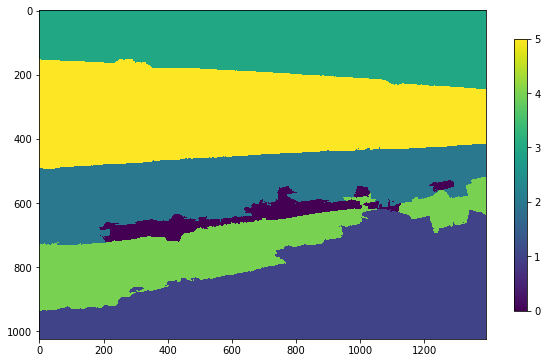

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(segments)
plt.colorbar(shrink=0.5)

Let's display that matrix ontop of the image

In [8]:
#load in image 
infile = infile.replace('.segments.pkl', '.jpg')
training_rgb = imread(infile)

In [9]:
print(np.shape(segments))
print(np.shape(training_rgb))

(1024, 1392)
(1040, 1392, 3)


Looks like there is a problem in the input data set: the label image is smaller than the input image!!

In [10]:
training_rgb = training_rgb[:1024,:,:]
print(np.shape(training_rgb))

(1024, 1392, 3)


In [11]:
cmap = plt.cm.get_cmap('RdYlBu', 6)    # 6 discrete colors

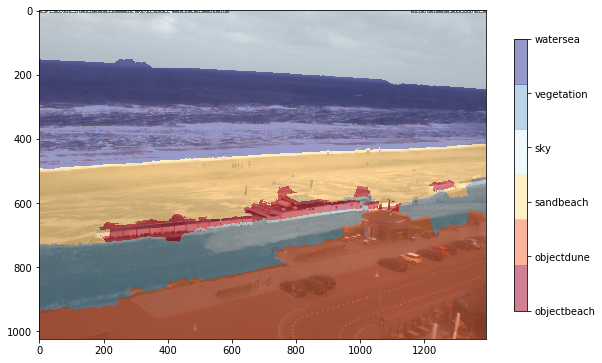

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(training_rgb)
plt.imshow(segments, alpha=0.5, cmap=cmap) # alpha is the opacity of an image alpha = 1 is totally opaque, alpha = 0 is transparent 
cb = plt.colorbar(shrink=0.5)
cb.set_ticks(np.arange(6))
cb.set_ticklabels(np.unique(classes))

In [13]:
## 2 is associated with sand
mask = (segments==2).astype('int')
## HOW DO YOU FIGURE OUT WHICH IS WHICH QUICKLY
## BRIEFLY EXPLAIN WHAT A MASK IS PERHAPS

(-0.5, 1391.5, 1023.5, -0.5)

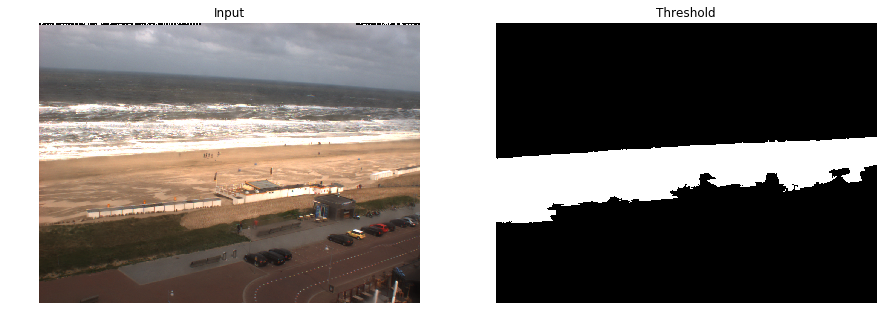

In [14]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(training_rgb)
plt.title('Input')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(mask, cmap=plt.cm.binary_r)
plt.title('Threshold')
plt.axis('off')

In [15]:
M, N, _ = np.shape(training_rgb)

It's generally good practice to scale imagery so classifiers are relatively insensitive to brightness and contrast in training imagery

We'll standardize imagery so it has zero mean and unit variance

C:\Users\rl587\AppData\Local\Continuum\anaconda3\envs\dl_tools_workshop\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


(-0.5, 1391.5, 1023.5, -0.5)

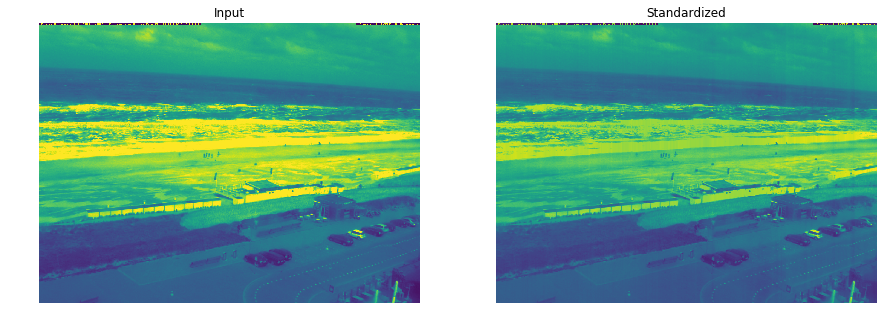

In [16]:
from sklearn import preprocessing
training_rgb_scaled = preprocessing.scale(training_rgb[:,:,0])

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(training_rgb[:,:,0])
plt.title('Input')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(training_rgb_scaled)
plt.title('Standardized')
plt.axis('off')

In [17]:
data_train = training_rgb_scaled.reshape(M*N, -1)[:,:] # grab the last dimension then flatten?? BUT WHY?
print(np.shape(data_train))

(1425408, 1)


The classification used in the learning step is represented as a binary MN vector

In [18]:
target = mask.reshape(M*N)
target

array([0, 0, 0, ..., 0, 0, 0])

### Training (fitting)

Sklearn provides a naive_bayes module containing a GaussianNB object that implements the supervised learning by the Gaussian Naïve Bayes method. 

One extremely fast way to create a simple model is to assume that the data is described by a Gaussian distribution with no covariance between dimensions. This model can be fit by simply finding the mean and standard deviation of the points within each label, which is all you need to define such a distribution.

In [19]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(data_train, target)

GaussianNB(priors=None)

In [20]:
gnb.class_prior_

array([0.8321463, 0.1678537])

The priors are just the relative abundances of each class (no sand and sand)

### Testing

Sand detection can be performed by reshaping and slicing in the same way as the training image. 

The predict method of GaussianNB performs the classification. The resulting classification vector can be reshaped to the original image dimensions for visualization.

Let's test at an image from the same place but at a different time

In [21]:
infile = 'data/1367407802.Wed.May.01_11_30_02.GMT.2013.jvspeijk.c2.snap.jpg' 
test_rgb = imread(infile)
test_rgb = test_rgb[:1024,:,:] # SHOULD WE ALWAYS USE 1024 OR IS THAT SPECIFIC TO THIS EXAMPLE, EXPLAIN THIS SLICING, WHAT AND WHY
test_rgb = preprocessing.scale(test_rgb[:,:,0]) # WHAT IS THIS SLICING TRYING TO DO
M_tst, N_tst = test_rgb.shape

C:\Users\rl587\AppData\Local\Continuum\anaconda3\envs\dl_tools_workshop\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


Next we'll read in the classes and segments and make a label image like we did before

In [22]:
infile = infile.replace('snap.jpg', 'snap.classes.pkl')
classes, codes = read_classes(infile)

In [23]:
infile = infile.replace('classes', 'segments')
print(infile)
mask = make_label_image(infile, codes)==2

data/1367407802.Wed.May.01_11_30_02.GMT.2013.jvspeijk.c2.snap.segments.pkl


Reshape the input data

In [24]:
data_test = test_rgb.reshape(M_tst * N_tst, -1)[:,:]

And run the model we trained on the first image

In [25]:
sand_pred = gnb.predict(data_test)
S = sand_pred.reshape(M_tst, N_tst)

(-0.5, 1391.5, 1023.5, -0.5)

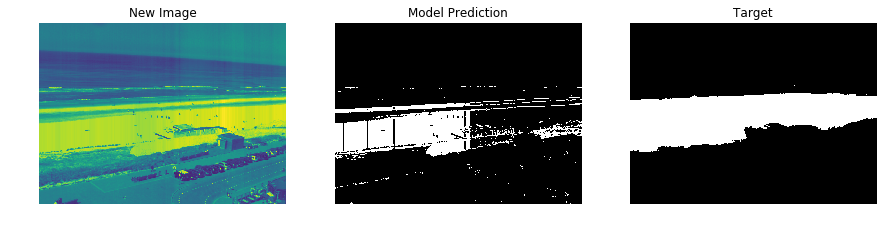

In [26]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(test_rgb)
plt.title('New Image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(S, cmap=plt.cm.binary_r)
plt.title('Model Prediction')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(mask, cmap=plt.cm.binary_r)
plt.title('Target')
plt.axis('off')

We can also estimate the probabilities of each class because we have a simple recipe to compute the likelihood $P({\rm features}~|~L_1)$ for any data point, and thus we can quickly compute the posterior ratio and determine which label is the most probable for a given point.

In [27]:
sand_pred = gnb.predict_proba(data_test)
Sprob = sand_pred.reshape(M_tst, N_tst, -1)

And plot the probabilities:

Text(0.5,1,'Probability of Sand')

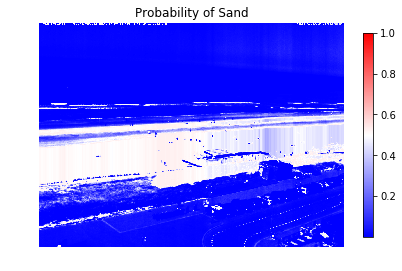

In [28]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(Sprob[:,:,1], cmap=plt.cm.bwr, vmax=1) # EXPLAIN THIS SLICING
plt.axis('off')
plt.colorbar(shrink=0.25)
plt.title('Probability of Sand')

(-0.5, 1391.5, 1023.5, -0.5)

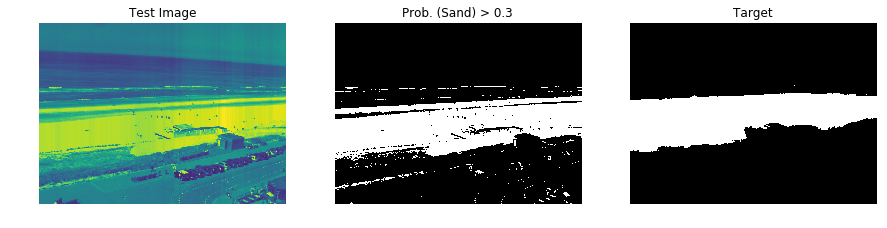

In [29]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(test_rgb)
plt.title('Test Image')
plt.axis('off')
plt.subplot(1,3,2)
#plt.imshow(test_rgb, alpha=0.6)
plt.imshow(Sprob[:,:,1]>.3, cmap=plt.cm.binary_r)
plt.title('Prob. (Sand) > 0.3')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(mask, cmap=plt.cm.binary_r)
plt.title('Target')
plt.axis('off')

Because naive Bayesian classifiers make such stringent assumptions about data, they will generally not perform as well as a more complicated model. 

What if we adjust the priors? Say, that there is a 50% prior likelihood of sand pixels

In [30]:
gnb = GaussianNB(priors=[0.5,0.5])
gnb.fit(data_train, target)

GaussianNB(priors=[0.5, 0.5])

In [31]:
sand_pred = gnb.predict_proba(data_test)
Sprob = sand_pred.reshape(M_tst, N_tst, -1)

Text(0.5,1,'Probability of Sand')

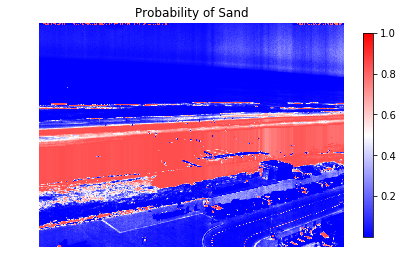

In [32]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(Sprob[:,:,1], cmap=plt.cm.bwr, vmax=1)
plt.axis('off')
plt.colorbar(shrink=0.25)
plt.title('Probability of Sand')

Much higher probability of sand, as expected

(-0.5, 1391.5, 1023.5, -0.5)

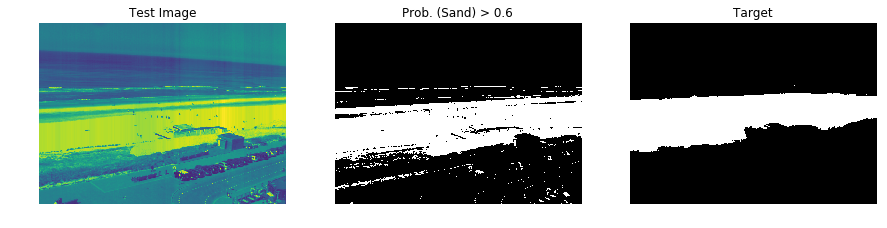

In [33]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(test_rgb)
plt.title('Test Image')
plt.axis('off')
plt.subplot(1,3,2)
#plt.imshow(test_rgb, alpha=0.6)
plt.imshow(Sprob[:,:,1]>.6, cmap=plt.cm.binary_r)
plt.title('Prob. (Sand) > 0.6')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(mask, cmap=plt.cm.binary_r)
plt.title('Target')
plt.axis('off')

## Naive Bayes with principal components

We can make things more complicated by
* adding more classes
* using feature extraction

Unlike before, we can build the feature extraction straight into the model using pipelines, which sequentially apply a list of transforms and a final estimator. In our case we'll use PCA as a transform again

In [34]:
from sklearn.decomposition import PCA 
from sklearn.pipeline import make_pipeline

gnb = GaussianNB()

pca = PCA(svd_solver='randomized', n_components=1, whiten=True, random_state=42) 
model = make_pipeline(pca, gnb)

(-0.5, 1391.5, 1023.5, -0.5)

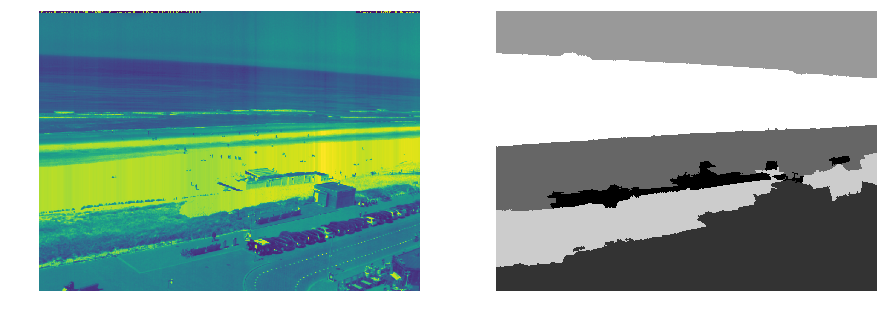

In [35]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(test_rgb)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(segments, cmap=plt.cm.binary_r)
plt.axis('off')

In [36]:
target = segments.reshape(M*N)
model.fit(data_test, target)

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=1, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=True)), ('gaussiannb', GaussianNB(priors=None))])

In [37]:
sand_pred = model.predict(data_train)
S = sand_pred.reshape(M, N)

Text(0.5,1,'Sand prediction')

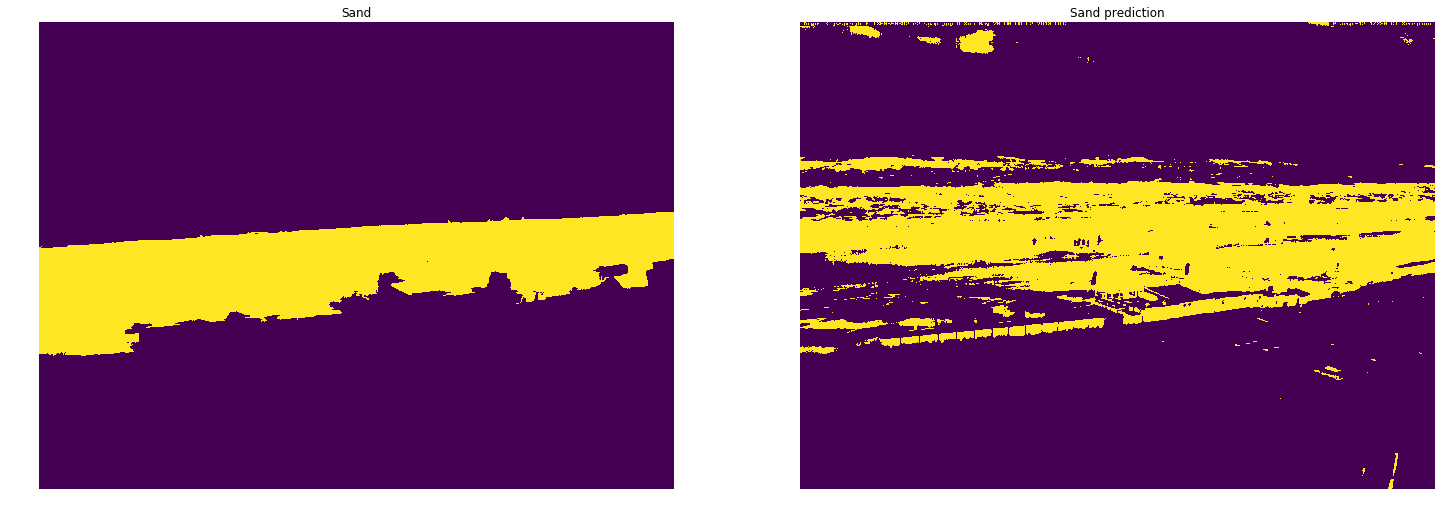

In [38]:
plt.figure(figsize=(25,15))
plt.subplot(1,2,1)
plt.imshow(segments==2)
plt.axis('off')
plt.title('Sand')
plt.subplot(1,2,2)
plt.imshow(S==2)
plt.axis('off')
plt.title('Sand prediction')

In this case, there wasn't much advantage using feature extraction with the NB model. Let's look at a different model

## Gaussian Mixture Model

There are other approaches that attempt to estimate the decision boundaries between different classes. One example is a Gaussian Mixture Model.

In [39]:
from sklearn.mixture import GaussianMixture

## BUT WHAT IS A GAUSSIAN MIXTURE MODEL IN lAYMANS TERMS?

We're going to use downscaled versions of images to speed up the process

In [40]:
from scipy.misc import imresize

infile = 'data/1367407802.Wed.May.01_11_30_02.GMT.2013.jvspeijk.c2.snap.jpg' 
test_rgb = imread(infile)

infile = 'data/1369558802.Sun.May.26_09_00_02.GMT.2013.jvspeijk.c2.snap.jpg'
training_rgb = imread(infile)

training_rgb = imresize(training_rgb, .125)
test_rgb = imresize(test_rgb, .125)

C:\Users\rl587\AppData\Local\Continuum\anaconda3\envs\dl_tools_workshop\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':
C:\Users\rl587\AppData\Local\Continuum\anaconda3\envs\dl_tools_workshop\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


(-0.5, 173.5, 129.5, -0.5)

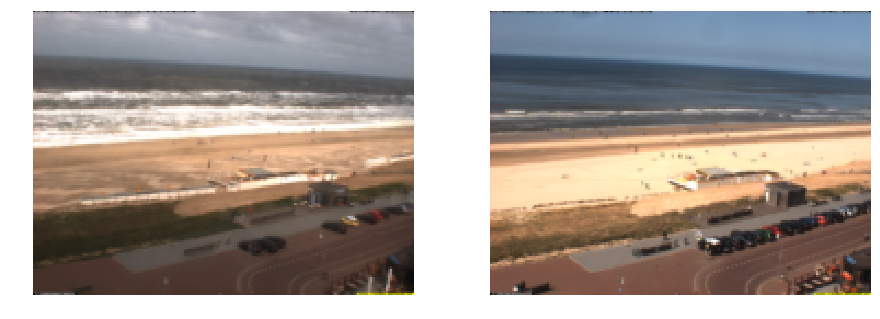

In [41]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(training_rgb)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(test_rgb)
plt.axis('off')

Fit the model with 4 components to the data

In [42]:
M, N, _ = training_rgb.shape
data = training_rgb.reshape(M*N, -1)[:,:]
gmm = GaussianMixture(n_components=4, covariance_type="tied").fit(data)
labels = gmm.predict(data)

GMMs use an expectation–maximization approach which qualitatively does the following:

Choose starting guesses for the location and shape

Repeat until converged:

* E-step: for each point, find weights encoding the probability of membership in each cluster
* M-step: for each cluster, update its location, normalization, and shape based on all data points, making use of the weights

We'll only show every 10th data point to save time

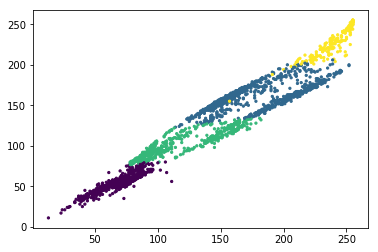

In [43]:
plt.scatter(data[::10, 0], data[::10, 1], c=labels[::10], s=5, cmap='viridis');

Apply to the test image and plot

In [44]:
newdata = test_rgb.reshape(M * N, -1)[:,:]
cluster = gmm.predict(newdata)
cluster = cluster.reshape(M, N)

(-0.5, 173.5, 129.5, -0.5)

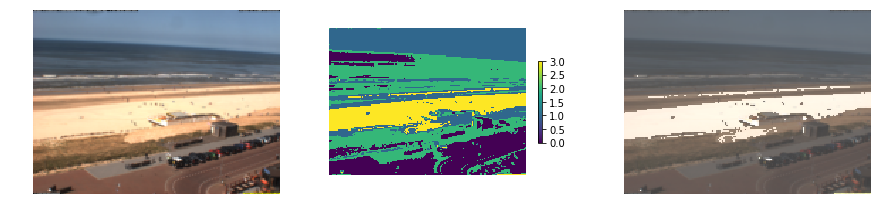

In [45]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(test_rgb)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(cluster) #, cmap=plt.cm.binary_r)
plt.axis('off')
plt.colorbar(shrink=0.1)
plt.subplot(1,3,3)
plt.imshow(test_rgb, alpha=0.6)
plt.imshow(cluster==3, cmap=plt.cm.binary_r, alpha=0.4)
plt.axis('off')

Because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments—in Scikit-Learn this is done using the predict_proba method. This returns a matrix of size [n_samples, n_clusters] which measures the probability that any point belongs to the given cluster:

In [46]:
post_probs = gmm.predict_proba(newdata)
np.shape(post_probs)

(22620, 4)

Text(0.5,1,'Probability of Sand')

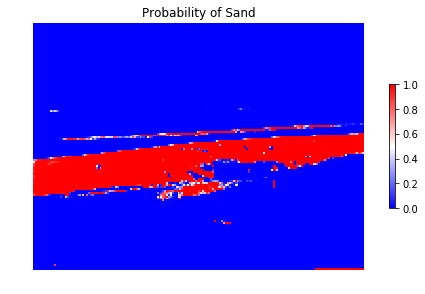

In [47]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.imshow(post_probs[:,3].reshape(M, N), cmap=plt.cm.bwr)
plt.axis('off')
plt.colorbar(shrink=0.5)
plt.title('Probability of Sand')

### How many components?

The fact that GMM is a generative model gives us a natural means of determining the optimal number of components for a given dataset. A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the likelihood of the data under the model, using cross-validation to avoid over-fitting. 

Another means of correcting for over-fitting is to adjust the model likelihoods using some analytic criterion such as the Akaike information criterion (AIC) or the Bayesian information criterion (BIC). Scikit-Learn's GMM estimator actually includes built-in methods that compute both of these, and so it is very easy to operate on this approach.

In [48]:
n_components = np.arange(2, 10)
models = [GaussianMixture(n, covariance_type='tied', random_state=0).fit(data)
          for n in n_components]

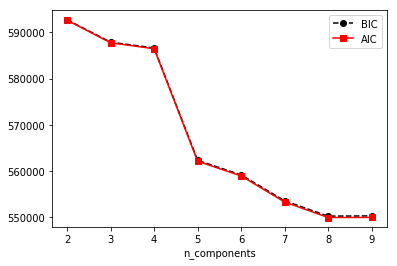

In [49]:
plt.plot(n_components, [m.bic(data) for m in models], 'k--o', label='BIC')
plt.plot(n_components, [m.aic(data) for m in models], 'r-s', label='AIC')
plt.legend(loc='best')
#plt.yscale('log')
plt.xlabel('n_components');

In this case, AIC and BIC are virtually the same

The optimal number of clusters is the value that minimizes the AIC or BIC. 

It says about 8 components would have been a better choice than 4


In [ ]:
## MY UNDERSTANDING OF AIC AND BIC FROM STATS LEADS ME TO BELIEVE THAT THE MORE COMPONENTS
##IN THE MODEL WOULD LEAD TO A HIGHER AIC AND BIC AFTER A CERTAIN POINT, THIS TREND SEEMS OPPOSITE THAT...
## MAYBE AIC STARTS TO INCREASE AFTER 10 COMPONENTS?

In [50]:
gmm = GaussianMixture(n_components=8, covariance_type="tied").fit(data)

In [51]:
newdata = test_rgb.reshape(M * N, -1)[:,:]
cluster = gmm.predict(newdata)
cluster = cluster.reshape(M, N)

We can look at the means for each cluster

In [52]:
print(gmm.means_[1])

[78.63296119 58.50011649 49.66566233]


In [53]:
print(gmm.means_[3])

[207.24710127 190.5782333  176.1671735 ]


In [54]:
sorted_means = np.argsort(np.mean(gmm.means_, axis=1))
sorted_means

array([7, 1, 4, 0, 6, 5, 3, 2], dtype=int64)

(-0.5, 173.5, 129.5, -0.5)

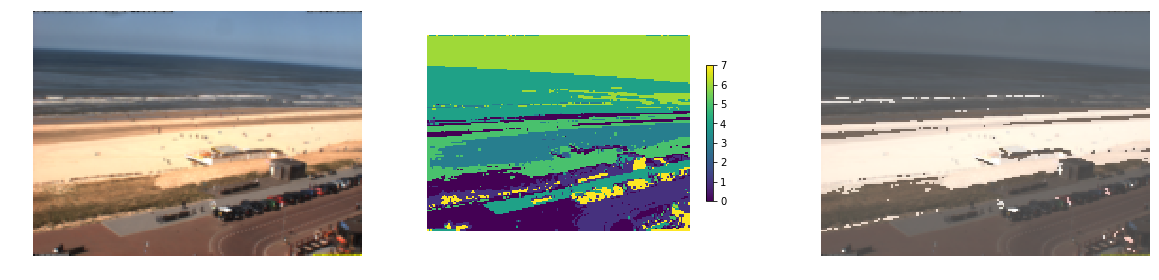

In [55]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(test_rgb)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(cluster) 
plt.axis('off')
plt.colorbar(shrink=0.25)
plt.subplot(1,3,3)
plt.imshow(test_rgb, alpha=0.6)
plt.imshow((cluster==sorted_means[-1])  
           + (cluster==sorted_means[-2])
           + (cluster==sorted_means[-3]), 
           cmap=plt.cm.binary_r, alpha=0.4)
plt.axis('off')

Looks like one cluster represents lower beach and another cluster represents upper beach

What choices did we make to arrive at this result?
* which cluster corresponds to what feature
* number of components
* type of covariance

How well does this approach generalize to other images?

In [56]:
infile = 'data/1368104406.Thu.May.09_13_00_06.GMT.2013.egmond.c5.snap.jpg'
test_rgb2 = imread(infile)

test_rgb2 = imresize(test_rgb2, .125)
M, N, _ = np.shape(test_rgb2)

C:\Users\rl587\AppData\Local\Continuum\anaconda3\envs\dl_tools_workshop\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


In [57]:
newdata = test_rgb2.reshape(M * N, -1)[:,:]
cluster = gmm.predict(newdata)
cluster = cluster.reshape(M, N)

(-0.5, 173.5, 129.5, -0.5)

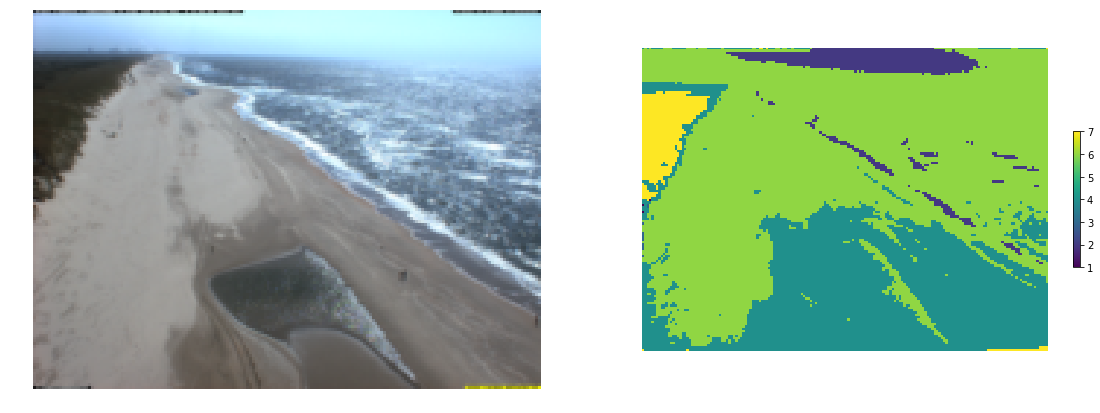

In [58]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(test_rgb2)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(cluster) 
plt.axis('off')
plt.colorbar(shrink=0.25)
plt.axis('off')

Not very well.

## Exercises

1. Training a classifier with ground truth imagery

We'll use the seabright dataset for this task. We have images and associated ground-truth labelled imagery

First, we'll load in the images (downsizng them to aid with speed)

In [59]:
import s3fs
fs = s3fs.S3FileSystem(anon=True)

root = 'esipfed/cdi-workshop'

images = [f for f in fs.ls(root+'/semseg_data/seabright/train') if f.endswith('.jpg')]
len(images)

Xtrain = []
for file in images:
    with fs.open(file, 'rb') as f:
        Xtrain.append(imresize(imread(f), .125))

C:\Users\rl587\AppData\Local\Continuum\anaconda3\envs\dl_tools_workshop\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if sys.path[0] == '':


Next we'll load the label images, contained in .mat files

We need to rescale these data the same way as we rescaled the imagery, but this time we also need to make sure that we keep the label images in whole integeres

In [60]:
from scipy.io import loadmat

classfiles = [f for f in fs.ls(root+'/semseg_data/seabright/train/gt') if f.endswith('.mat')]

ytrain = []
for file in classfiles:
    with fs.open(file) as f:
        dat = loadmat(f)['class']
        datr = np.round(imresize(dat, .125, interp='nearest')/255 * np.max(dat))
        ytrain.append(datr)

C:\Users\rl587\AppData\Local\Continuum\anaconda3\envs\dl_tools_workshop\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


Always a good idea to plot some data just to check it is as you expect

(-0.5, 919.5, 613.5, -0.5)

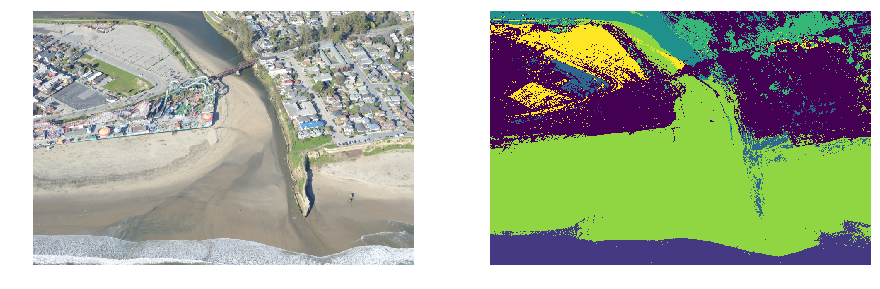

In [61]:
plt.figure(figsize=(15,10))
plt.subplot(121); plt.imshow(Xtrain[0]); plt.axis('off')
plt.subplot(122); plt.imshow(ytrain[0]); plt.axis('off')

In [70]:
num_images, M, N, num_channels = np.shape(Xtrain)


920

Ok, go ahead and fit a Naive Bayes model to the first pair of images

In [73]:

gnb = GaussianNB()
gnb.fit(Xtrain[0].reshape(M*N, -1)[:,:], ytrain[0].reshape(M*N))

GaussianNB(priors=None)

Using that model, predict the labels for the next image in the sequence

In [74]:
data = Xtrain[1].reshape(M * N, -1)[:,:]
pred = gnb.predict(data)
S = pred.reshape(M, N)

Make a 4-part plot showing 
1. the original image 
2. the original label image
3. the model-predicted label image
4. the pixels associated with water

How well does it do?

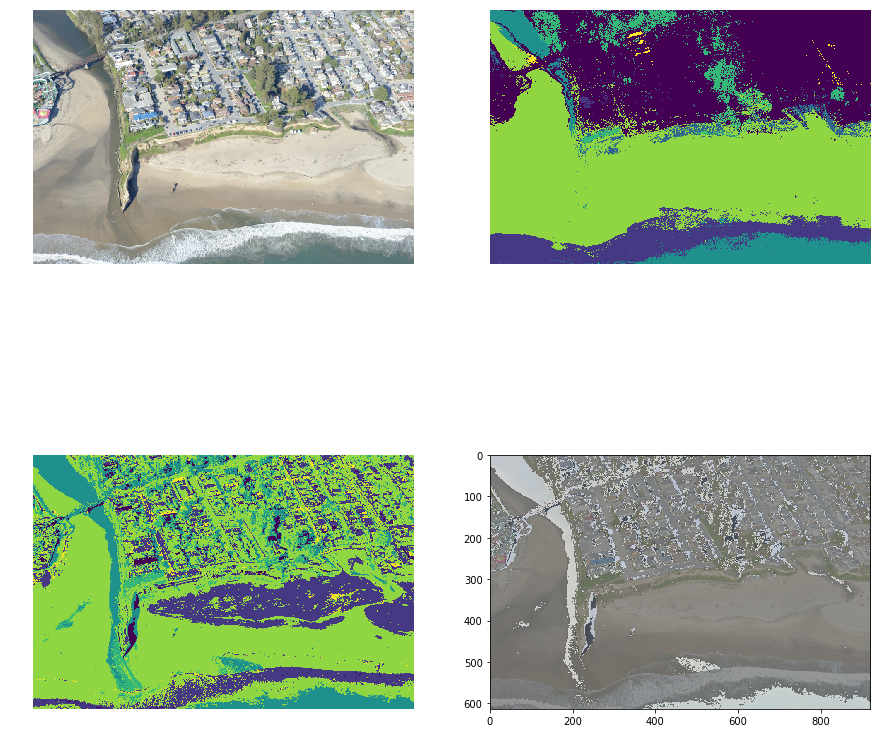

In [77]:
plt.figure(figsize = (15,15))
plt.subplot(2,2,1);plt.imshow(Xtrain[1]); plt.axis('off')
plt.subplot(2,2,2);plt.imshow(ytrain[1]); plt.axis('off')
plt.subplot(2,2,3);plt.imshow(S); plt.axis('off')
plt.subplot(2,2,4);plt.imshow(Xtrain[1], alpha=0.6);
plt.imshow(S==3, cmap=plt.cm.binary_r, alpha=0.4)

In order to fit a model to the entire dataset, we need to arrange the data a little different

The model fitting function expected the image data to be arranged N_features x N_channels (3)

and the label data to be 

N_features 

In [80]:
X = [] # create a empty list called X
for item in Xtrain: # for all items in the Xtrain
    X.append(item.reshape(M*N, -1)[:,:]) #append the list x to contain that item reshaped into M*N with the 3rd dimension what does [:,:] do?
   

Y = []
for item in ytrain:
    Y.append(item.reshape(M*N))

Xtrain2 = np.vstack(X)
ytrain2 = np.hstack(Y)

In [81]:
np.shape(ytrain2)

(3954160,)

In [82]:
np.shape(Xtrain2)

(3954160, 3)

Create a new model and fit to this data

In [83]:
gnb.fit(Xtrain2, ytrain2)

GaussianNB(priors=None)

Fit the model to an image (you choose) and make a plot as before, exploring how well the model predicts various landcover classes

In [93]:
data = Xtrain[3].reshape(M * N, -1)[:,:]
pred = gnb.predict(data)
S = pred.reshape(M, N)


array([[3., 3., 3., ..., 5., 5., 1.],
       [3., 3., 3., ..., 1., 1., 1.],
       [3., 3., 3., ..., 1., 1., 1.],
       ...,
       [5., 5., 5., ..., 3., 3., 3.],
       [5., 5., 5., ..., 3., 3., 3.],
       [5., 5., 5., ..., 3., 3., 3.]])

(-0.5, 919.5, 613.5, -0.5)

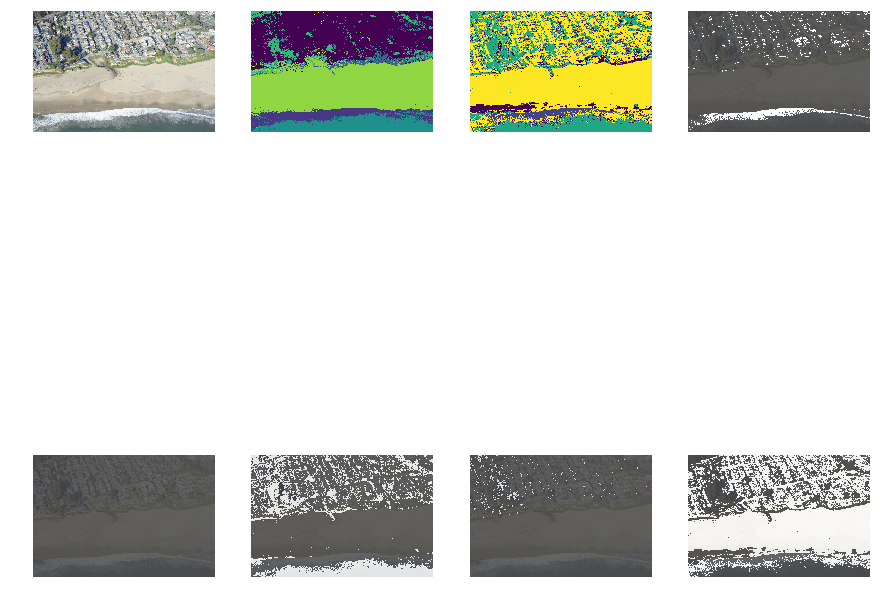

In [96]:
plt.figure(figsize = (15,15))
plt.subplot(2,4,1);plt.imshow(Xtrain[3]); plt.axis('off')
plt.subplot(2,4,2);plt.imshow(ytrain[3]); plt.axis('off')
plt.subplot(2,4,3);plt.imshow(S); plt.axis('off')
plt.subplot(2,4,4);plt.imshow(Xtrain[3], alpha=0.4);
plt.imshow(S==1, cmap=plt.cm.binary_r, alpha=0.6); plt.axis('off')
plt.subplot(2,4,5);plt.imshow(Xtrain[3], alpha=0.4);
plt.imshow(S==2, cmap=plt.cm.binary_r, alpha=0.6); plt.axis('off')
plt.subplot(2,4,6);plt.imshow(Xtrain[3], alpha=0.4);
plt.imshow(S==3, cmap=plt.cm.binary_r, alpha=0.6); plt.axis('off')
plt.subplot(2,4,7);plt.imshow(Xtrain[3], alpha=0.4);
plt.imshow(S==4, cmap=plt.cm.binary_r, alpha=0.6); plt.axis('off')
plt.subplot(2,4,8);plt.imshow(Xtrain[3], alpha=0.4);
plt.imshow(S==5, cmap=plt.cm.binary_r, alpha=0.6); plt.axis('off')